# Historical CM4 and ESM4 vs ERA5 Wind Data
vas- northward, uas- eastward

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

# Historical CM4

In [3]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_historical = df_uas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)
Uas_historical = ds_uas_historical_use.uas #extracting uas variable
Uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(305, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [4]:
df_u_historical

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9917,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,uas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


In [5]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)
historical_vas=ds_vas_historical.vas

In [6]:
#slicing into seasons and averaging it, also selecting south pole region 
vas_his_seasonal=historical_vas.sel(time=slice('1995-01-01','2014-12-01')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
vas_his_seasonal
uas_his_seasonal=Uas_historical.sel(time=slice('1995-01-01','2014-12-01')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
uas_his_seasonal

<xarray.DataArray 'uas' (season: 4, lat: 35, lon: 288)>
dask.array<getitem, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [7]:
## merge winds by merging eastward and northward.
#extracting just uas and vas data
Uas_historical1 = ds_uas_historical_use.uas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-01','2014-12-01'))
historical_vas1=ds_vas_historical.vas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-01','2014-12-01'))

his_mergewinds = xr.merge([Uas_historical1,historical_vas1]) # merge winds to make it easy
xmerge = his_mergewinds.lon #extracting the lon component fomr the mergewinds array
ymerge = his_mergewinds.lat
umerge = his_mergewinds.uas 
vmerge = his_mergewinds.vas
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector formula
## average
timeaveragemerge = his_mergewinds.sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
timeaveragemerge

### slicing the speed for the south pole
speedslice = speedmerge.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
## UAS seasonal dataset

uas_his_seasonal
## VAS seasonal plot
vas_his_seasonal
## merging the UAS seasonal and Vas seasonal to get merge seasonal
his_seasonalmerge = xr.merge([uas_his_seasonal,vas_his_seasonal])
his_seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [8]:
## calculating the seasonal wind speed
seasonal_speedmerge = np.sqrt(np.square(his_seasonalmerge.uas) + np.square(his_seasonalmerge.vas))

## slicing the summer speed
Summer_szn_speed = seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= his_seasonalmerge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= his_seasonalmerge.sel(season='JJA')

## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= his_seasonalmerge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= his_seasonalmerge.sel(season='SON')

# Historical ESM4 

In [9]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)

In [10]:
esm4_vas

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    vas        (time, lat, lon) float32 dask.array<chunksize=(596, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    tracking_id:            hdl:21.14100/39b6212a-af33-4131-b50b-7b10c22594ab...
    variable_id:            vas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/39b6212a-af33-4131-b50b-7b10c22594ab...
    version_id:             v20190726

In [11]:
uase4=esm4_uas.uas.sel(time=slice('1995-01-01','2014-12-01')) #eastward wind variable
## slicing the uase4 into south polar lat and isolating the end of the historical run
ESM4_Antsliceuas = uase4.sel(lat=slice(-89.5,-55))
ESM4_Antsliceuas
## grouping the data into seasons and averaging the seasons
ESM4_uas_seasonal = ESM4_Antsliceuas.groupby('time.season').mean(dim='time')
ESM4_uas_seasonal

## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
vase4 = esm4_vas.vas.sel(time=slice('1995-01-01','2014-12-01')) #northward wind variable
## slicing the vase4 into south polar lat and isolating the end of the historical run
ESM4_Antslicevas = vase4.sel(lat=slice(-89.5,-55))
ESM4_Antslicevas
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_seasonal = ESM4_Antslicevas.groupby('time.season').mean(dim='time')
ESM4_vas_seasonal

<xarray.DataArray 'vas' (season: 4, lat: 35, lon: 288)>
dask.array<stack, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [12]:
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.lon
esm4_ymerge=mergedwindse4.lat
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge)).sel(lat=slice(-90,-55))
esm4_speed_merge
#wind speed around antarctica 

esm4_timeaveragemerge = mergedwindse4.sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [13]:
ESM4_speedslice = esm4_speed_merge.sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
ESM4_speedslice

<xarray.DataArray (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [14]:
#ESM4_vas_seasonal defined earlier
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge= xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])

##
## calculating the seasonal wind speed
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))


In [15]:
## slicing the summer speed
ESM4_Summer_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
ESM4_Summer_szn= esm4_seasonalmerge.sel(season='DJF') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the winter speed
ESM4_winter_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
## Slicing winter season from seasonalmerge
ESM4_winter_szn= esm4_seasonalmerge.sel(season='JJA') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the fall speed
ESM4_fall_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
## Slicing fall season from seasonalmerge
ESM4_fall_szn= esm4_seasonalmerge.sel(season='MAM') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the spring speed
ESM4_spring_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
## Slicing spring season from seasonalmerge
ESM4_spring_szn= esm4_seasonalmerge.sel(season='SON') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

# ERA5 data

In [47]:
#wind speed
era5_windspeed=xr.open_dataset('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_wind_speed_1940-2024_monthly_ensemble.nc')
ERA5_combine_windspeed =era5_windspeed.sel(expver=1).combine_first(era5_windspeed.sel(expver=5))
ERA5_combine_windspeed.load()

<xarray.Dataset>
Dimensions:    (time: 1013, number: 10, latitude: 361, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-05-01
Data variables:
    si10       (time, number, latitude, longitude) float32 6.298 6.298 ... 9.893
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-20 18:15:01 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [52]:
era5_windspeed_use=ERA5_combine_windspeed.mean(dim='number').sel(time=slice('1995-01-01','2015-12-01'))
era5_windspeed_use

<xarray.Dataset>
Dimensions:    (time: 252, latitude: 361, longitude: 720)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 1995-01-01 1995-02-01 ... 2015-12-01
Data variables:
    si10       (time, latitude, longitude) float32 4.759 4.759 ... 9.893 9.893

In [69]:
# Resample the data by season and compute the mean wind speed for each season
#era5_seasonal_windspeed = era5_windspeed_use.resample(time='QS-DEC').mean()
#era5_seasonal_windspeed

In [70]:
# Add a season coordinate for easier grouping
#era5_seasonal_windspeed['season'] = (era5_seasonal_windspeed['time.month'] % 12 + 1).to_index().map({
    1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON',
    12: 'DJF'})

IndentationError: unexpected indent (304043705.py, line 3)

In [71]:
# Group by season and compute the mean wind speed for each season
#seasonal_mean_windspeed = era5_seasonal_windspeed.groupby('season').mean()
#seasonal_mean_windspeed

In [42]:
#use=era5_windspeed.sel(expver=1).mean(dim='number').sel(time=slice('1995-01-01','2015-12-01'))
#use

In [41]:
#era5_use=use.groupby('time.season')
#era5_use

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [44]:
##season=era5_use.groupby('time.season')
#season

In [72]:
#creating seasonal slices of the data with updated data
era5_seasonal=era5_windspeed_use.groupby('time.season').mean(dim='time')
era5_seasonal
era5_summer=seasonal_mean_windspeed.sel(season='DJF')
era5_winter=seasonal_mean_windspeed.sel(season='JJA')
era5_spring=seasonal_mean_windspeed.sel(season='SON')
era5_fall=seasonal_mean_windspeed.sel(season='MAM')

# Bar Plots

## annual wind speed

In [78]:
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
plateau_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
ross_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
lowwest_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
loweast_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
filchner_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
peninsula_wind_total_ESM4=(ESM4_speedslice*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

plateau_wind_total_CM4=(speedslice*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
ross_wind_total_CM4=(speedslice*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
lowwest_wind_total_CM4=(speedslice*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
loweast_wind_total_CM4=(speedslice*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
filchner_wind_total_CM4=(speedslice*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
peninsula_wind_total_CM4=(speedslice*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

plateau_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
ross_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
lowwest_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
loweast_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
filchner_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')
peninsula_wind_total_ERA5=(era5_windspeed_use*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude').mean(dim='time')

In [79]:
plat_value_ESM4_total=print(plateau_wind_total_ESM4.values)
ross_value_ESM4_total= print(ross_wind_total_ESM4.values)
west_value_ESM4_total=print(lowwest_wind_total_ESM4.values)
east_value_ESM4_total=print(loweast_wind_total_ESM4.values)
filch_value_ESM4_total=print(filchner_wind_total_ESM4.values)
pen_value_ESM4_total=print(peninsula_wind_total_ESM4.values)

4.5586243
3.0141594
5.5071807
6.738554
2.5200515
3.8387973


In [80]:
plat_value_CM4_total=print(plateau_wind_total_CM4.values)
ross_value_CM4_total= print(ross_wind_total_CM4.values)
west_value_CM4_total=print(lowwest_wind_total_CM4.values)
east_value_CM4_total=print(loweast_wind_total_CM4.values)
filch_value_CM4_total=print(filchner_wind_total_CM4.values)
pen_value_CM4_total=print(peninsula_wind_total_CM4.values)

4.541173
2.9819815
5.4170055
6.590887
2.4373682
3.678369


In [81]:
plat_value_ERA5_total=print(plateau_wind_total_ERA5.values)
ross_value_ERA5_total= print(ross_wind_total_ERA5.values)
west_value_ERA5_total=print(lowwest_wind_total_ERA5.values)
east_value_ERA5_total=print(loweast_wind_total_ERA5.values)
filch_value_ERA5_total=print(filchner_wind_total_ERA5.values)
pen_value_ERA5_total=print(peninsula_wind_total_ERA5.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 8.638>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 8.023>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 8.417>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 9.36>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 7.867>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    number   int32 ...
Data variables:
    si10     float32 8.496>


In [82]:
esm4_regional_annual_values=[4.610894,
2.9960504,
5.5168953,
6.7622037,
2.511684,
3.7957954]
cm4_regional_annual_values=[4.556596,
2.9305322,
5.388403,
6.6122456,
2.4263186,
3.619592]
era5_wind_total_values=[8.637709,
8.023329,
8.4173155,
9.360203,
7.8669825,
8.49571]

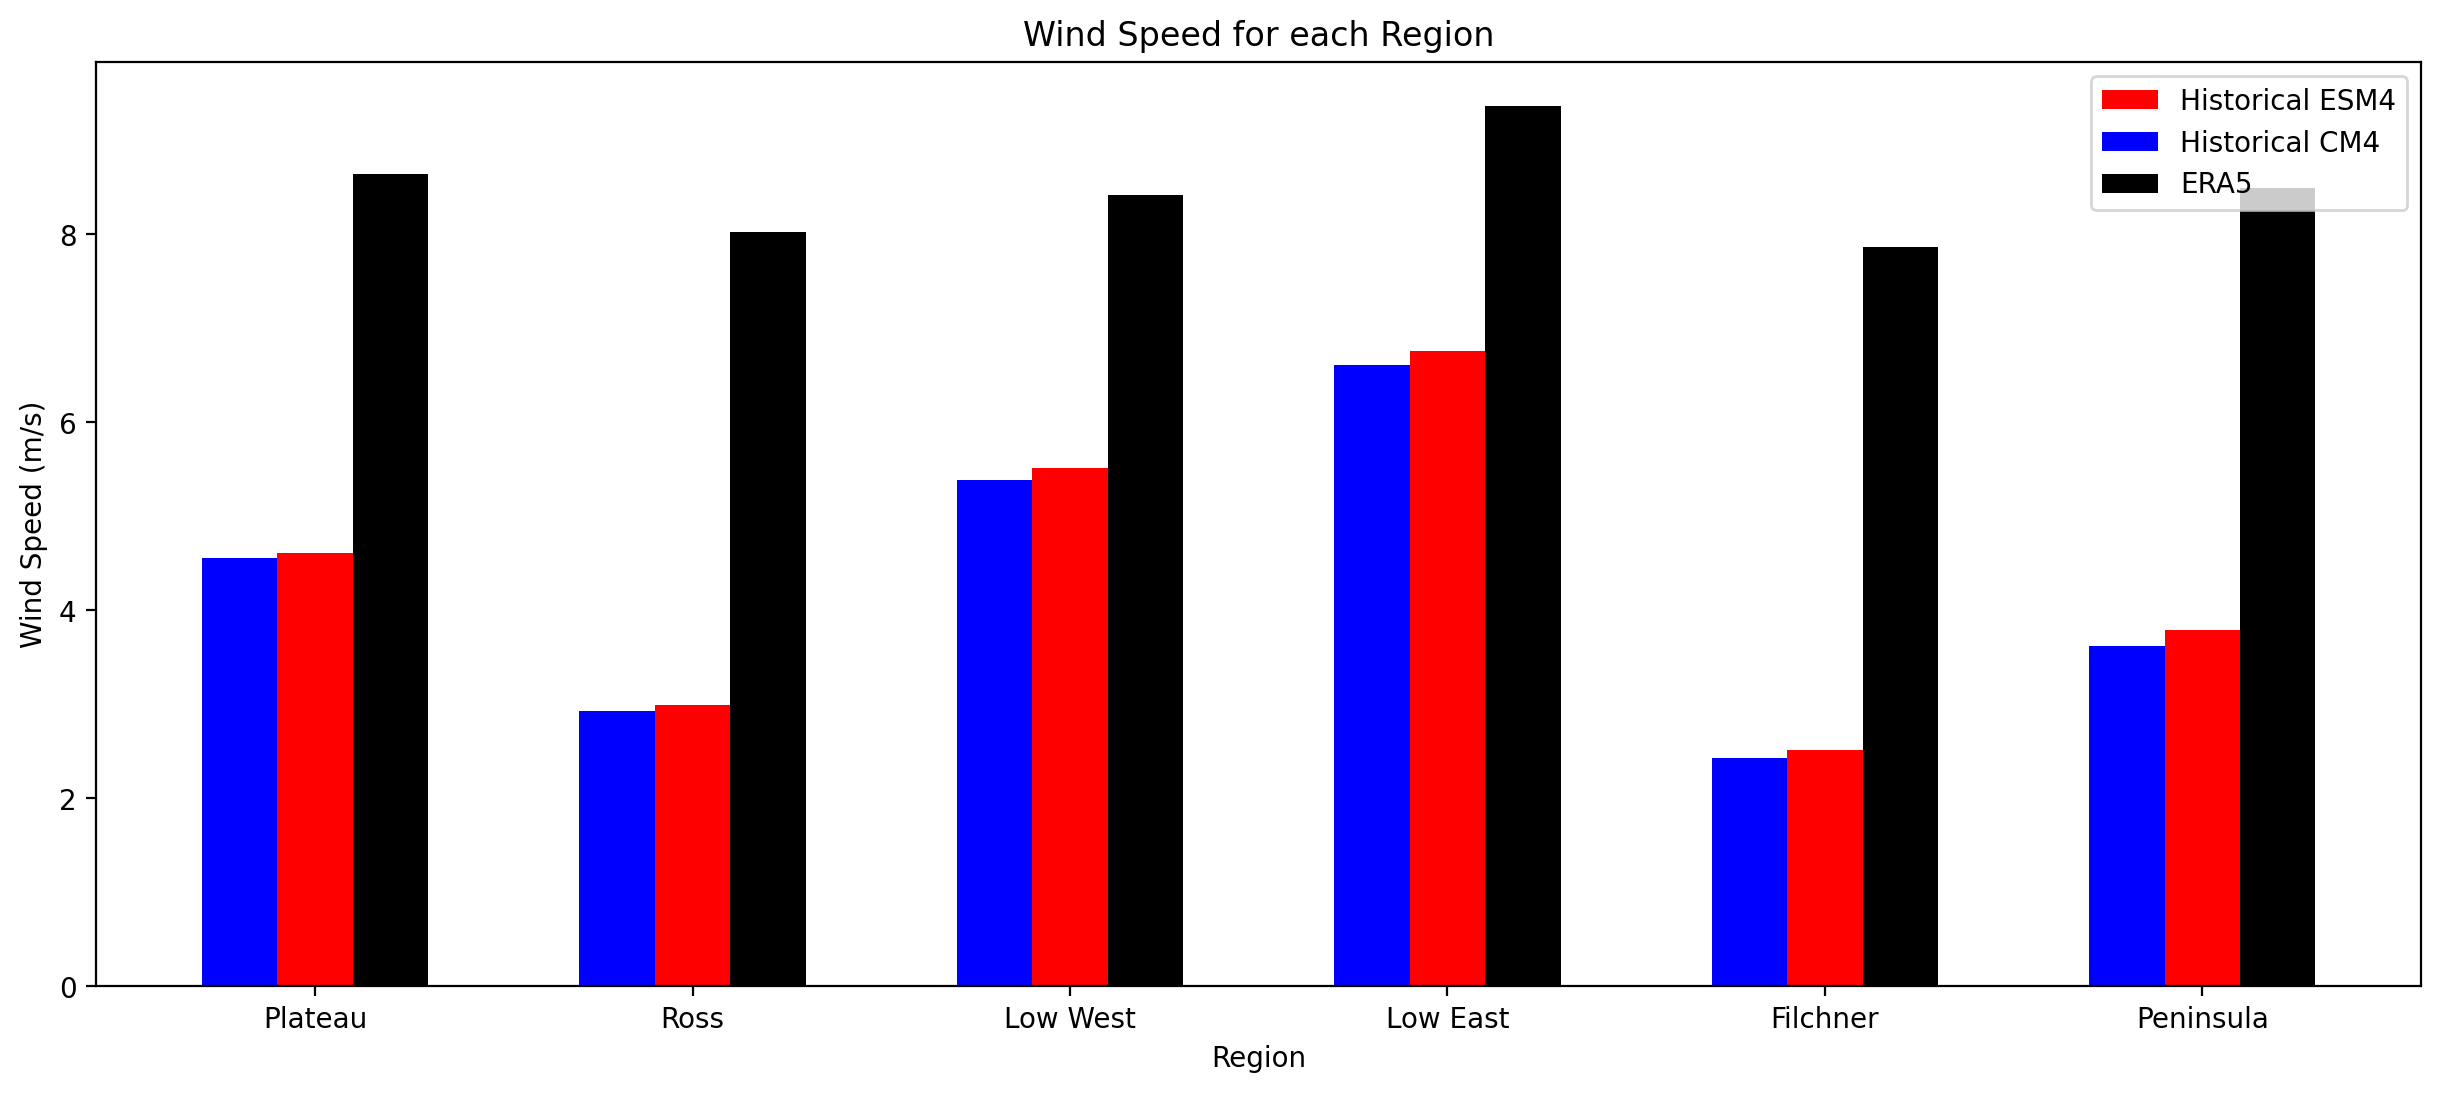

In [83]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = cm4_regional_annual_values
ESM4 = esm4_regional_annual_values
ERA=era5_wind_total_values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'Historical ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'Historical CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Wind Speed for each Region") 
plt.legend() 

plt.show()

# Summer

In [74]:
#time is already averaged out from speed slice
#here we are averaging the wind speed of each region into one value to compare on a bar plot
#this is annual windspeed averaged over 500 years
summer_plateau_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
summer_ross_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
summer_lowwest_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
summer_loweast_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
summer_filchner_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
summer_peninsula_wind_total_ESM4=(ESM4_Summer_szn_speed*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')

summer_plateau_wind_total_CM4=(Summer_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
summer_ross_wind_total_CM4=(Summer_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
summer_lowwest_wind_total_CM4=(Summer_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
summer_loweast_wind_total_CM4=(Summer_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
summer_filchner_wind_total_CM4=(Summer_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
summer_peninsula_wind_total_CM4=(Summer_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')

summer_plateau_wind_total_ERA5=(era5_summer*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_ross_wind_total_ERA5=(era5_summer*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_lowwest_wind_total_ERA5=(era5_summer*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_loweast_wind_total_ERA5=(era5_summer*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_filchner_wind_total_ERA5=(era5_summer*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
summer_peninsula_wind_total_ERA5=(era5_summer*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [75]:
summer_plat_value_ESM4_total=print(summer_plateau_wind_total_ESM4.values)
summer_ross_value_ESM4_total= print(summer_ross_wind_total_ESM4.values)
summer_west_value_ESM4_total=print(summer_lowwest_wind_total_ESM4.values)
summer_east_value_ESM4_total=print(summer_loweast_wind_total_ESM4.values)
summer_filch_value_ESM4_total=print(summer_filchner_wind_total_ESM4.values)
summer_pen_value_ESM4_total=print(summer_peninsula_wind_total_ESM4.values)

3.2872381
2.1670747
3.7612076
4.6322627
1.50615
2.6539218


In [76]:
summer_plat_value_CM4_total=print(summer_plateau_wind_total_CM4.values)
summer_ross_value_CM4_total= print(summer_ross_wind_total_CM4.values)
summer_lowwest_value_CM4_total=print(summer_lowwest_wind_total_CM4.values)
summer_loweast_value_CM4_total=print(summer_loweast_wind_total_CM4.values)
summer_filch_value_CM4_total=print(summer_filchner_wind_total_CM4.values)
summer_pen_value_CM4_total=print(summer_peninsula_wind_total_CM4.values)

3.0487778
1.8314
3.2749057
4.2149057
1.2664886
2.1681902


In [84]:
summer_plat_value_ERA5_total=print(summer_plateau_wind_total_ERA5.values)
summer_ross_value_ERA5_total= print(summer_ross_wind_total_ERA5.values)
summer_west_value_ERA5_total=print(summer_lowwest_wind_total_ERA5.values)
summer_east_value_ERA5_total=print(summer_loweast_wind_total_ERA5.values)
summer_filch_value_ERA5_total=print(summer_filchner_wind_total_ERA5.values)
summer_pen_value_ERA5_total=print(summer_peninsula_wind_total_ERA5.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    season   <U3 'DJF'
    number   int32 ...
    time     datetime64[ns] ...
Data variables:
    si10     float32 8.022>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    season   <U3 'DJF'
    number   int32 ...
    time     datetime64[ns] ...
Data variables:
    si10     float32 7.496>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    season   <U3 'DJF'
    number   int32 ...
    time     datetime64[ns] ...
Data variables:
    si10     float32 7.802>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    season   <U3 'DJF'
    number   int32 ...
    time     datetime64[ns] ...
Data variables:
    si10     float32 8.686>
<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    season   <U3 'DJF'
    number   int32 ...
    time     datetime64[ns] ...
Data variables:
    si10     float32 7.531>


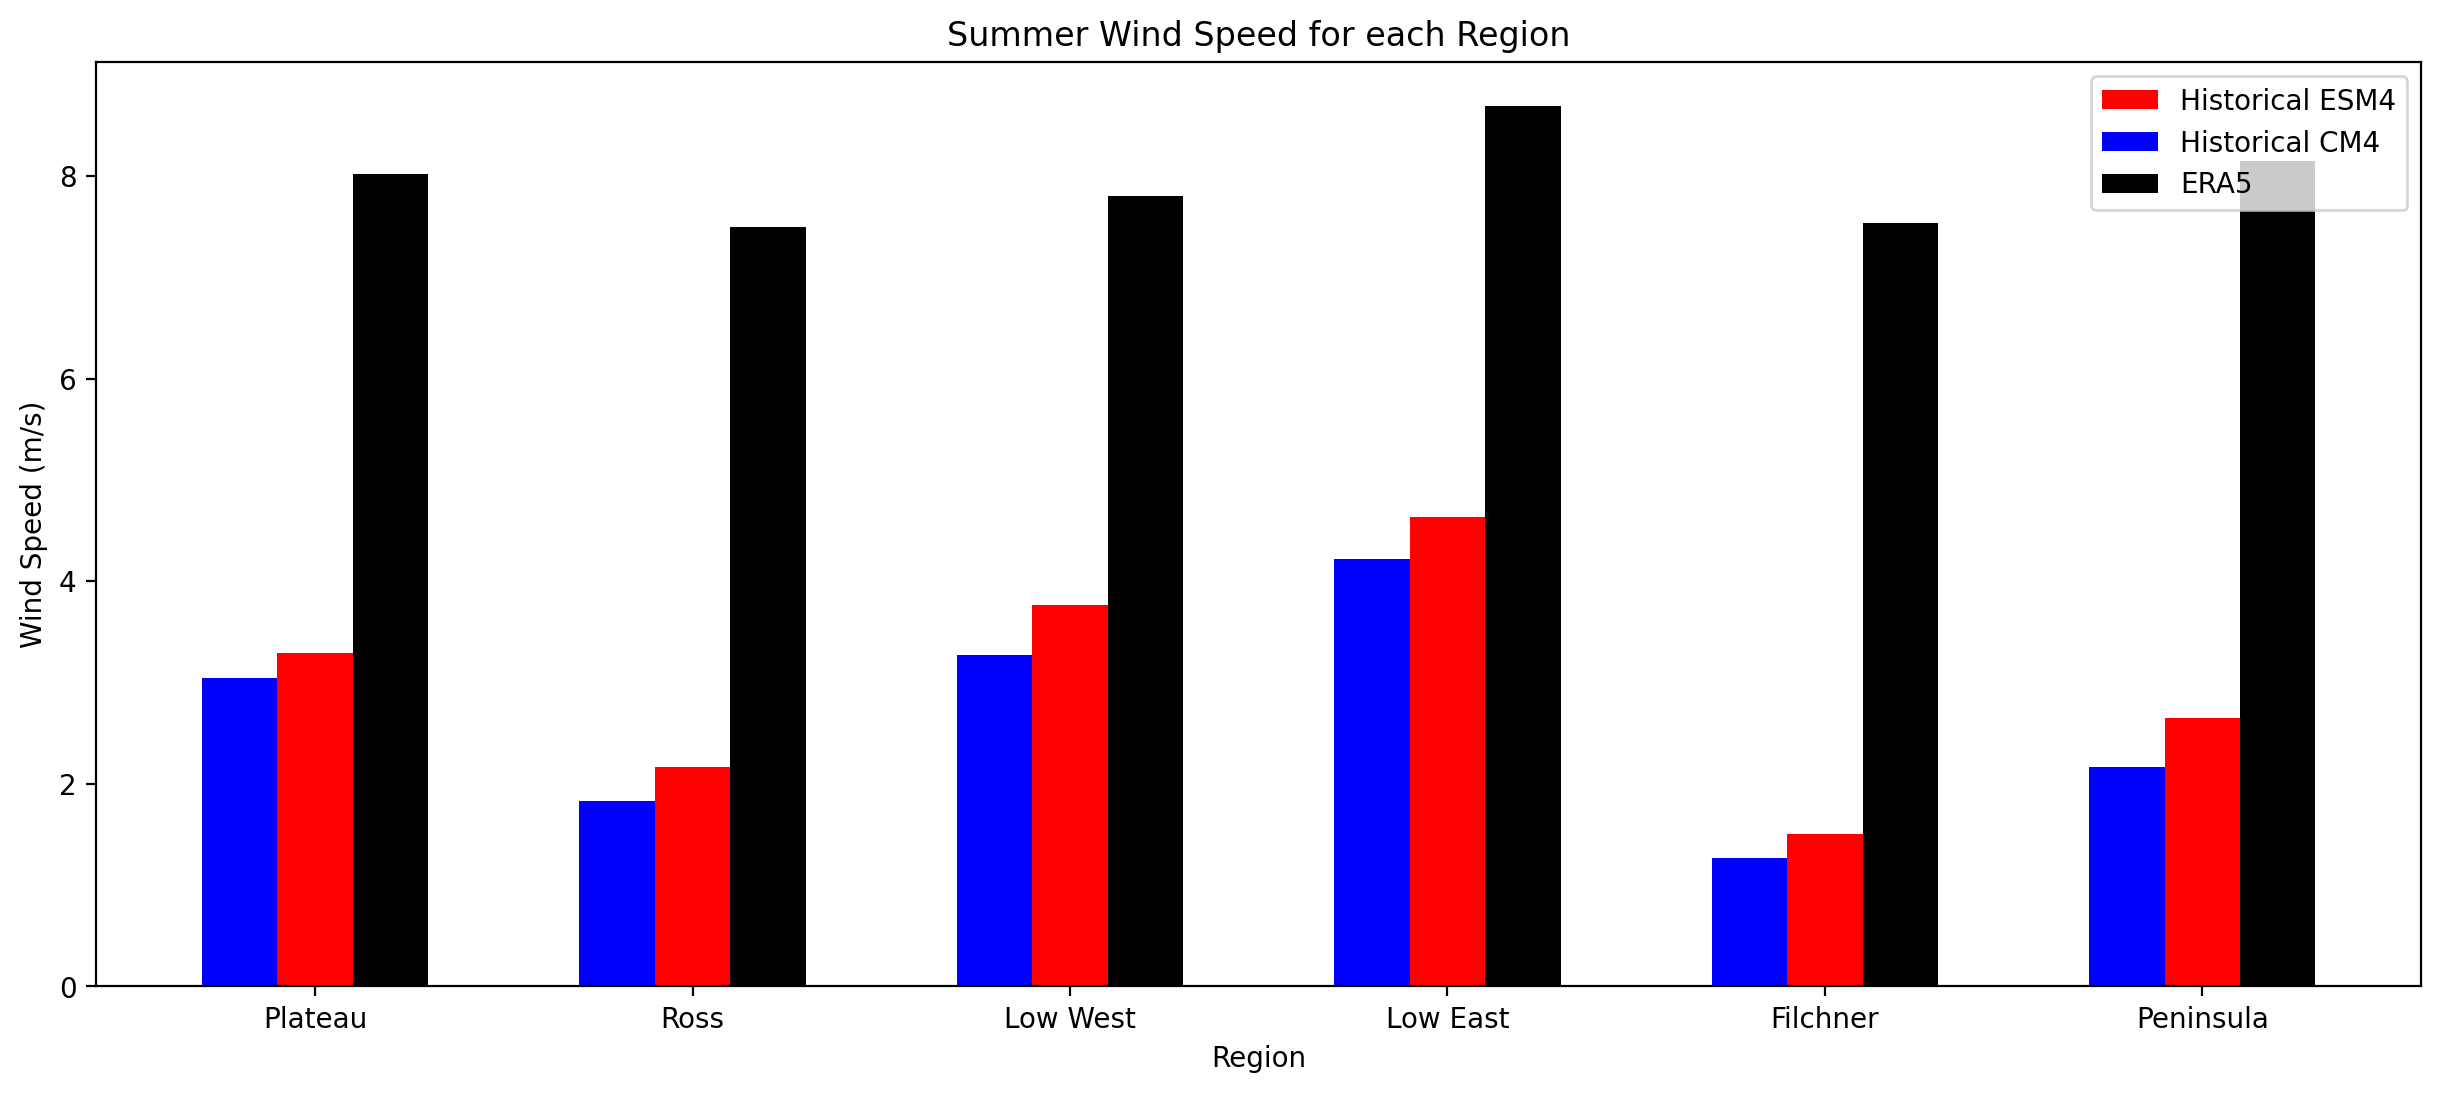

In [85]:
#bar plot showing differences in cm4 and esm4 data for regional annual windspeed 
fig, ax= plt.subplots(figsize= (15,6))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [3.0487778,
1.8314,
3.2749057,
4.2149057,
1.2664886,
2.1681902]
ESM4 = [3.2872381,
2.1670747,
3.7612076,
4.6322627,
1.50615,
2.6539218]

ERA=[8.022,7.496,7.802,8.686,7.531,8.148]
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4, 0.2, label = 'Historical ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4, 0.2, label = 'Historical CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA, 0.2, label = 'ERA5', color= 'k') 

plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Wind Speed (m/s)") 
plt.title("Summer Wind Speed for each Region") 
plt.legend() 

plt.show()

# Winter

In [ ]:
#esm4 winter
winter_plateau_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.plateau_ESM4)).mean(dim='lat').mean(dim='lon')
winter_ross_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.ross_ESM4)).mean(dim='lat').mean(dim='lon')
winter_lowwest_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.lowwest_ESM4)).mean(dim='lat').mean(dim='lon')
winter_loweast_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.loweast_ESM4)).mean(dim='lat').mean(dim='lon')
winter_filchner_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.filchner_ESM4)).mean(dim='lat').mean(dim='lon')
winter_peninsula_temp_total_ESM4=(ESM4_winter_szn_speed_rename*(mask_ESM4.peninsula_ESM4)).mean(dim='lat').mean(dim='lon')
#cm4 winter
winter_plateau_temp_total_CM4=(Winter_szn_speed*(mask_CM4.plateau_CM4)).mean(dim='lat').mean(dim='lon')
winter_ross_temp_total_CM4=(Winter_szn_speed*(mask_CM4.ross_CM4)).mean(dim='lat').mean(dim='lon')
winter_lowwest_temp_total_CM4=(Winter_szn_speed*(mask_CM4.lowwest_CM4)).mean(dim='lat').mean(dim='lon')
winter_loweast_temp_total_CM4=(Winter_szn_speed*(mask_CM4.loweast_CM4)).mean(dim='lat').mean(dim='lon')
winter_filchner_temp_total_CM4=(Winter_szn_speed*(mask_CM4.filchner_CM4)).mean(dim='lat').mean(dim='lon')
winter_peninsula_temp_total_CM4=(Winter_szn_speed*(mask_CM4.peninsula_CM4)).mean(dim='lat').mean(dim='lon')
#winter wind speed era5
winter_plateau_wind_total_ERA5=(era5_winter*(mask_ERA5.plateau_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_ross_wind_total_ERA5=(era5_winter*(mask_ERA5.ross_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_lowwest_wind_total_ERA5=(era5_winter*(mask_ERA5.lowwest_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_loweast_wind_total_ERA5=(era5_winter*(mask_ERA5.loweast_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_filchner_wind_total_ERA5=(era5_winter*(mask_ERA5.filchner_ERA5)).mean(dim='latitude').mean(dim='longitude')
winter_peninsula_wind_total_ERA5=(era5_winter*(mask_ERA5.peninsula_ERA5)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
winter_plat_value_ESM4_total=print(winter_plateau_temp_total_ESM4.values)
winter_ross_value_ESM4_total= print(winter_ross_temp_total_ESM4.values)
winter_lowwest_value_ESM4_total=print(winter_lowwest_temp_total_ESM4.values)
winter_loweast_value_ESM4_total=print(winter_loweast_temp_total_ESM4.values)
winter_filch_value_ESM4_total=print(winter_filchner_temp_total_ESM4.values)
winter_pen_value_ESM4_total=print(winter_peninsula_temp_total_ESM4.values)

In [ ]:
winter_plat_value_CM4_total=print(winter_plateau_temp_total_CM4.values)
winter_ross_value_CM4_total= print(winter_ross_temp_total_CM4.values)
winter_lowwest_value_CM4_total=print(winter_lowwest_temp_total_CM4.values)
winter_loweast_value_CM4_total=print(winter_loweast_temp_total_CM4.values)
winter_filch_value_CM4_total=print(winter_filchner_temp_total_CM4.values)
winter_pen_value_CM4_total=print(winter_peninsula_temp_total_CM4.values)

In [ ]:
winter_plat_value_ERA5_total=print(winter_plateau_wind_total_ERA5.values)
winter_ross_value_ERA5_total= print(winter_ross_wind_total_ERA5.values)
winter_west_value_ERA5_total=print(winter_lowwest_wind_total_ERA5.values)
winter_east_value_ERA5_total=print(winter_loweast_wind_total_ERA5.values)
winter_filch_value_ERA5_total=print(winter_filchner_wind_total_ERA5.values)
winter_pen_value_ERA5_total=print(winter_peninsula_wind_total_ERA5.values)

# Spring

# Fall